In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
env = gym.make("FrozenLake-v1", render_mode = "human")
print(f'Number of possible actions: {env.action_space} that correspond to left, down, right, up')
print(f'Number of states: {env.observation_space} that correspond to a 4x4 grid of positions')

Number of possible actions: Discrete(4) that correspond to left, down, right, up
Number of states: Discrete(16) that correspond to a 4x4 grid of positions


### 1. Action Space
The agent takes a interger for action, where that integer decides direction to move in which can be:

- 0: LEFT
- 1: DOWN
- 2: RIGHT
- 3: UP

### 2. Observation Space
The observation is a value representing the agent’s current position as current_row * nrows + current_col. For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15.

### 3. Starting State
The episode starts with the player in state [0] at the location [0, 0] in the map

### 4. Rewards

- Reach goal: 1
- Reach hole: 0
- Reach frozen: 0

#### Here is a demo (performed ten times)

【Change！！】At the suggestion of our teacher, we use, is_slippery=False

In [3]:
env = gym.make("FrozenLake-v1", is_slippery=False)# , render_mode="human")

num_wins = 0
num_trials = 100

for i in range(num_trials):
    observation = env.reset()
    terminated = False
    while not terminated:
        action = env.action_space.sample()  # 选择随机动作
        result = env.step(action)
        observation, reward, terminated, info = result[0], result[1], result[2], result[3]
        if terminated and observation == 15:  # 15 是宝藏的索引
            num_wins += 1

print(f"Number of wins: {num_wins} out of {num_trials} trials")

env.close()

Number of wins: 2 out of 100 trials


## Comparison of Q-Learning and Random Strategy

In [4]:
def random_policy(env):
    num_wins = 0
    for i in range(n_episode):
        env.reset()
        terminated = False

        while not terminated:
            state = env.s  # the state where the agent is
            action = env.action_space.sample()  # choose a random action
            new_state, reward, terminated, truncated, info = env.step(action)

            if terminated and new_state == 15:
                num_wins += 1

    return num_wins / n_episode  # return the win rate

The Q-value between the current state $s$ and the current action $a$ is denoted as $Q(s, a)$.

The Q-value corresponding to the best action $a'$ in the next state $s'$ given the current state $s$ is denoted as $\max_{a'} Q(s', a')$.

$r$ represents the reward obtained after taking the action $a$.

According to the formula of the Q-learning algorithm, we can define the new Q-value $Q'(s, a)$ as:

$$ Q'(s,a) = (1 - \alpha) \cdot Q(s,a) + \alpha \cdot (r + \gamma \cdot \max_{a'} Q(s',a')) $$

Here, $\alpha$ is the learning rate, which controls the weight between the new Q-value and the old Q-value. $\gamma$ is the discount factor, which balances the importance of current and future rewards.


In [5]:
def q_learning(n_episode, alpha, gamma):
    policy = np.zeros((16, 4))  # Initialize the policy matrix, 16 states, 4 actions each
    num_wins = 0  # Record the number of wins
    win_rates = []  # Store the win rate for each episode

    for i in range(n_episode):
        env = gym.make("FrozenLake-v1")
        env.reset()

        n_move = 0
        terminated = False

        while not terminated:
            if n_move > 10000:
                raise Exception("Too many attempts, failed")
            n_move += 1
            state = env.s

            action = np.argmax(policy[state, :])

            new_state, reward, terminated, truncated, info = env.step(action)

            if terminated and new_state == 15:  # 15 is the index of the treasure
                num_wins += 1

            qmaxnew = np.max(policy[new_state, :])
            policy[state, action] = (1 - alpha) * policy[state, action] + alpha * (reward + gamma * qmaxnew)

        env.close()
        win_rates.append(num_wins / (i+1))  # calculate the win rate for this episode
    return win_rates


#### Use epsilon-greedy strategy

In [6]:
def q_learning_eg(n_episode, alpha, gamma, decay=None):
    policy = np.zeros((16, 4))  # Initialize the policy matrix, 16 states, 4 actions each
    num_wins = 0  # Record the number of wins
    win_rates = []  # Store the win rate for each episode

    for i in range(n_episode):
        env = gym.make("FrozenLake-v1")
        env.reset()

        n_move = 0
        terminated = False

        while not terminated:
            n_move += 1
            state = env.s

            # choose a random action if using an eps-greedy policy
            if decay is not None and np.random.rand() < np.exp(-decay * i):
                action = np.random.randint(4)

            # choose a random action if policy is not defined
            elif not np.any(policy[state, :]):
                action = np.random.randint(4)

            # follow the policy
            else:
                action = np.argmax(policy[state, :])

            new_state, reward, terminated, truncated, info = env.step(action)

            if terminated and new_state == 15:  # 15 is the index of the treasure
                num_wins += 1

            qmaxnew = np.max(policy[new_state, :])
            policy[state, action] = (1 - alpha) * policy[state, action] + alpha * (reward + gamma * qmaxnew)

        env.close()
        win_rates.append(num_wins / (i+1))  # calculate the win rate for this episode
    return win_rates


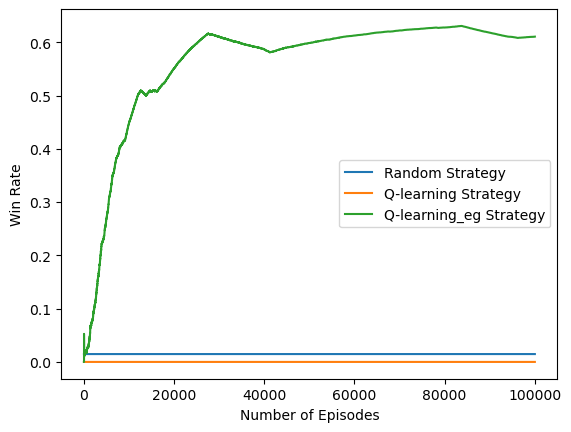

In [7]:
n_episode = 100000
alpha = 0.1
gamma = 0.9
decay = 0.001

env = gym.make("FrozenLake-v1", is_slippery=False)
random_win_rate = random_policy(env) 
q_win_rates_1 = q_learning(n_episode, alpha, gamma)  
q_win_rates_2 = q_learning_eg(n_episode, alpha, gamma, decay)  

plt.plot(range(n_episode), [random_win_rate]*n_episode, label='Random Strategy')
plt.plot(range(n_episode), q_win_rates_1, label='Q-learning Strategy')
plt.plot(range(n_episode), q_win_rates_2, label='Q-learning_eg Strategy')
plt.xlabel('Number of Episodes')
plt.ylabel('Win Rate')
plt.legend()
plt.show()

It is normal for a Q-learning strategy without epsilon-greedy exploration to have a success rate of 0. The reason is that it always chooses the same actions for a given state during training. This may cause the algorithm to fall into a suboptimal strategy, i.e., it always takes the same action.

## Add Saras to the comparison

Q-learning and Sarsa are an off-policy algorithm and an on-policy algorithm. 
- The difference between the two algorithms lies in the difference of Q-value updates. 
- In other words, Q-learning considers the maximum Q value in the next moment when it is updated, while Sarsa is an on-the-fly update, and only the Q value in the next moment is considered when it is updated.

SARSA stands for "State-Action-Reward-State-Action" and is an on-policy algorithm, meaning it learns the value of the policy currently being used to select actions. In SARSA, we update the Q-value based on the current state-action pair and the next state-action pair that is chosen according to the current policy.

#### Tips: 

Since we found that using the epsilon-greedy strategy is better, we use the saras strategy to select epsilon directly using the epsilon-greedy strategy

In [8]:
def sarsa(n_episode, alpha, gamma, decay=None):
    policy = np.zeros((16, 4))  # Initialize the policy matrix, 16 states, 4 actions each
    num_wins = 0  # Record the number of wins
    win_rates = []  # Store the win rate for each episode

    for i in range(n_episode):
        env = gym.make("FrozenLake-v1")
        env.reset()

        n_move = 0
        terminated = False

        # Choose the first action using an epsilon-greedy policy
        if decay is not None and np.random.rand() < np.exp(-decay * i):
            action = np.random.randint(4)
        elif not np.any(policy[env.s, :]):
            action = np.random.randint(4)
        else:
            action = np.argmax(policy[env.s, :])

        while not terminated:
            n_move += 1
            state = env.s

            new_state, reward, terminated, truncated, info = env.step(action)

            # Choose the next action using an epsilon-greedy policy
            if decay is not None and np.random.rand() < np.exp(-decay * i):
                next_action = np.random.randint(4)
            elif not np.any(policy[new_state, :]):
                next_action = np.random.randint(4)
            else:
                next_action = np.argmax(policy[new_state, :])

            if terminated and new_state == 15:  # 15 is the index of the treasure
                num_wins += 1

            qnext = policy[new_state, next_action]
            policy[state, action] = (1 - alpha) * policy[state, action] + alpha * (reward + gamma * qnext)

            action = next_action

        env.close()
        win_rates.append(num_wins / (i+1))  # calculate the win rate for this episode
    return win_rates

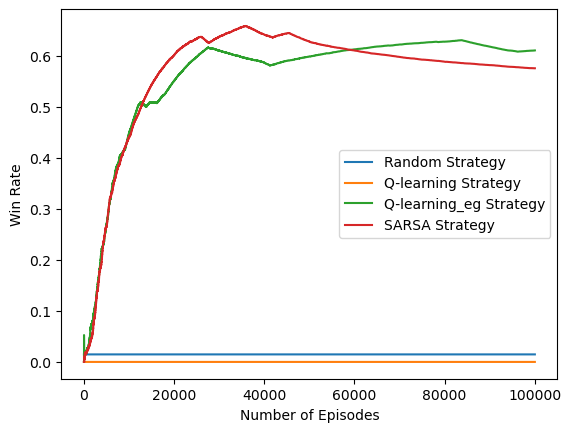

In [9]:
n_episode = 100000
alpha = 0.1
gamma = 0.9
decay = 0.001

env = gym.make("FrozenLake-v1", is_slippery=False)
s_win_rates = sarsa(n_episode, alpha, gamma, decay)

plt.plot(range(n_episode), [random_win_rate]*n_episode, label='Random Strategy')
plt.plot(range(n_episode), q_win_rates_1, label='Q-learning Strategy')
plt.plot(range(n_episode), q_win_rates_2, label='Q-learning_eg Strategy')
plt.plot(range(n_episode), s_win_rates, label='SARSA Strategy')
plt.xlabel('Number of Episodes')
plt.ylabel('Win Rate')
plt.legend()
plt.show()

### TODO
- Adjusting the parameters of Qlearning and saras(Using gradient descent?/ del the random action?) -> is_slippery=False ==> Qlearning/Saras == 100%
    - Saras without epsilon-greedy strategy? 
- Improve the process of presenting results
- Add some explanation/summary